# SDWFS AGN Color Histogram Plot
## Author: Benjamin Floyd

Generates the histogram that was traditionally on the side of the redshift--color plot.

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.cosmology import z_at_value, FlatLambdaCDM
from astropy.table import Table, join
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator
from scipy.interpolate import interp1d

%matplotlib inline
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 14})

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [3]:
# Read in the SDWFS photometric catalog
sdwfs_main = Table.read('Data_Repository/Catalogs/Bootes/SDWFS/ch2v33_sdwfs_2009mar3_apcorr_matched_ap4_Main_v0.4.cat.gz',
                        names=['ID', 'IRAC_RA', 'IRAC_DEC', 'B_APFLUX4', 'R_APFLUX4', 'I_APFLUX4', 'B_APFLUXERR4',
                               'R_APFLUXERR4', 'I_APFLUXERR4', 'B_APMAG4', 'R_APMAG4', 'I_APMAG4', 'B_APMAGERR4',
                               'R_APMAGERR4', 'I_APMAGERR4', 'CH1_APFLUX4', 'CH2_APFLUX4', 'CH3_APFLUX4', 'CH4_APFLUX4',
                               'CH1_APFLUXERR4', 'CH2_APFLUXERR4', 'CH3_APFLUXERR4', 'CH4_APFLUXERR4',
                               'CH1_APFLUXERR4_BROWN', 'CH2_APFLUXERR4_BROWN', 'CH3_APFLUXERR4_BROWN',
                               'CH4_APFLUXERR4_BROWN', 'CH1_APMAG4', 'CH2_APMAG4', 'CH3_APMAG4', 'CH4_APMAG4',
                               'CH1_APMAGERR4', 'CH2_APMAGERR4', 'CH3_APMAGERR4', 'CH4_APMAGERR4',
                               'CH1_APMAGERR4_BROWN', 'CH2_APMAGERR4_BROWN', 'CH3_APMAGERR4_BROWN',
                               'CH4_APMAGERR4_BROWN', 'STARS_COLOR', 'STARS_MORPH', 'CLASS_STAR', 'MBZ_FLAG_4_4_4'],
                        format='ascii')

# Read in the photometric redshift catalog
sdwfs_photz = Table.read('Data_Repository/Catalogs/Bootes/SDWFS/mbz_v0.06_prior_bri12_18p8.cat.gz',
                         names=['ID', 'PHOT_Z', 'col3', 'col4', 'col5', 'col6', 'col7'],
                         format='ascii',
                         include_names=['ID', 'PHOT_Z'])

# Join the two catalogs together
sdwfs_cat = join(sdwfs_main, sdwfs_photz, keys='ID')

In [4]:
# Impose our magnitude cuts used in AGN selection for 3.6 um and 4.5 um and require SNR > 5 for 5.8 um and 8.0 um.
sdwfs_cat = sdwfs_cat[(sdwfs_cat['CH1_APMAG4'] > 10.00) & (sdwfs_cat['CH1_APMAG4'] <= 18.30) &  # 10. < [3.6] <= 18.3
                      (sdwfs_cat['CH2_APMAG4'] > 10.45) & (sdwfs_cat['CH2_APMAG4'] <= 17.46) &  # 10.45 < [4.5] <= 17.46
                      (sdwfs_cat['CH3_APFLUX4'] / sdwfs_cat['CH3_APFLUXERR4'] >= 5) &           # SNR_5.8 >= 5
                      (sdwfs_cat['CH4_APFLUX4'] / sdwfs_cat['CH4_APFLUXERR4'] >= 5)]            # SNR_8.0 >= 5

In [5]:
# For convenience, add columns for the two colors
sdwfs_cat['CH1_CH2_COLOR'] = sdwfs_cat['CH1_APMAG4'] - sdwfs_cat['CH2_APMAG4']
sdwfs_cat['CH3_CH4_COLOR'] = sdwfs_cat['CH3_APMAG4'] - sdwfs_cat['CH4_APMAG4']

In [6]:
# Make AGN selections using the Stern+05 wedge selection
stern_agn = sdwfs_cat[(sdwfs_cat['CH3_CH4_COLOR'] > 0.6) &
                      (sdwfs_cat['CH1_CH2_COLOR'] > 0.2 * sdwfs_cat['CH3_CH4_COLOR'] + 0.18) &
                      (sdwfs_cat['CH1_CH2_COLOR'] > 2.5 * sdwfs_cat['CH3_CH4_COLOR'] - 3.5)]

# donley_agn = sdwfs_cat[(sdwfs_cat['CH3_CH1_LOG_FLUX'] >= 0.08) & (sdwfs_cat['CH4_CH2_LOG_FLUX'] >= 0.15) &
#                        (sdwfs_cat['CH4_CH2_LOG_FLUX'] >= 1.21 * sdwfs_cat['CH3_CH1_LOG_FLUX'] - 0.27) &
#                        (sdwfs_cat['CH4_CH2_LOG_FLUX'] <= 1.21 * sdwfs_cat['CH3_CH1_LOG_FLUX'] + 0.27) &
#                        (sdwfs_cat['CH2_APFLUX4'] > sdwfs_cat['CH1_APFLUX4']) &
#                        (sdwfs_cat['CH3_APFLUX4'] > sdwfs_cat['CH2_APFLUX4']) &
#                        (sdwfs_cat['CH4_APFLUX4'] > sdwfs_cat['CH3_APFLUX4'])]

In [7]:
# Identify the IDs of the objects outside the Stern-wedge selection to create a sample of non-AGN.
stern_complement_ids = list(set(sdwfs_cat['ID']) - set(stern_agn['ID']))
non_agn = sdwfs_cat[np.in1d(sdwfs_cat['ID'], stern_complement_ids)]

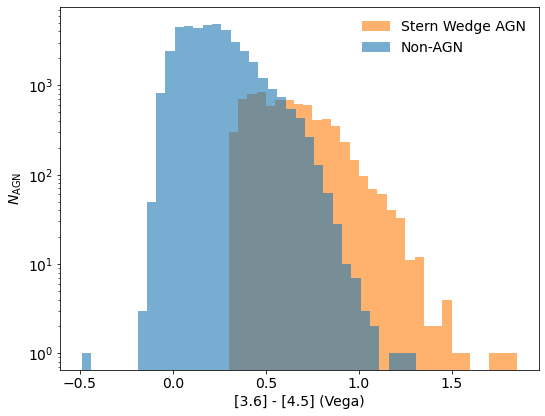

In [8]:
fig, ax = plt.subplots(figsize=(7.8, 6))
binwidth = 0.05
min_z = 0.
max_z = 1.8
bins_nonAGN = np.arange(non_agn['CH1_CH2_COLOR'].min(), non_agn['CH1_CH2_COLOR'].max() + binwidth, binwidth)
bins_AGN = np.arange(stern_agn['CH1_CH2_COLOR'].min(), stern_agn['CH1_CH2_COLOR'].max() + binwidth, binwidth)
ax.hist(stern_agn['CH1_CH2_COLOR'][(stern_agn['PHOT_Z'] > min_z) & (stern_agn['PHOT_Z'] < max_z)], bins=bins_AGN, color='tab:orange', alpha=0.6, label='Stern Wedge AGN')
ax.hist(non_agn['CH1_CH2_COLOR'][(non_agn['PHOT_Z'] > min_z) & (non_agn['PHOT_Z'] < max_z)], bins=bins_nonAGN, color='tab:blue', alpha=0.6, label='Non-AGN')
# ax_hist.axhline(y=0.7, color='k', linewidth=2)
ax.legend(frameon=False)
ax.set(ylabel=r'$N_\mathrm{AGN}$', xlabel='[3.6] - [4.5] (Vega)', yscale='log')
fig.tight_layout()
# fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/Publication_Plots/SDWFS_AGN_color_histogram_publication.pdf')

In [9]:
with open('Data_Repository/Project_Data/SPT-IRAGN/SDWFS_background/SDWFS_purity_color.json', 'r') as f:
    sdwfs_purity_data = json.load(f)
z_bins = sdwfs_purity_data['redshift_bins'][:-1]
agn_purity_color = interp1d(z_bins, sdwfs_purity_data['purity_90_colors'], kind='previous')

In [10]:
# Bin all three versions by redshift
all_sdwfs_bins = np.digitize(sdwfs_cat['PHOT_Z'], z_bins)
agn_bins = np.digitize(stern_agn['PHOT_Z'], z_bins)
non_agn_bins = np.digitize(non_agn['PHOT_Z'], z_bins)

all_sdwfs_binned = sdwfs_cat.group_by(all_sdwfs_bins)
stern_agn_binned = stern_agn.group_by(agn_bins)
non_agn_binned = non_agn.group_by(non_agn_bins)

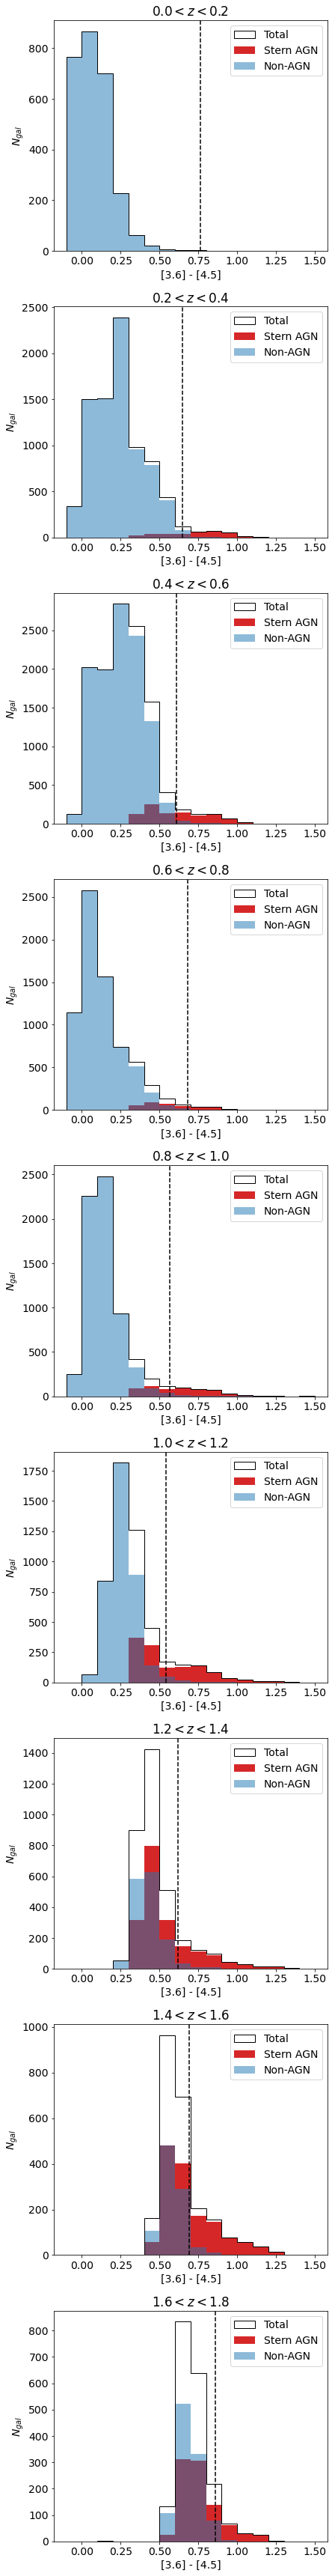

In [11]:
color_bins = np.arange(-0.1, 1.51, 0.1)
fig, axes = plt.subplots(nrows=len(z_bins)-1, figsize=(6.4, len(all_sdwfs_binned.groups.keys) * 4.8))
for i, (all_bin, agn_bin, non_agn_bin, ax) in enumerate(zip(all_sdwfs_binned.groups, stern_agn_binned.groups, non_agn_binned.groups, axes.flatten())):
    ax.hist(all_bin['CH1_CH2_COLOR'], bins=color_bins, histtype='step', color='k', label='Total')
    ax.hist(agn_bin['CH1_CH2_COLOR'], bins=color_bins, color='tab:red', label='Stern AGN')
    ax.hist(non_agn_bin['CH1_CH2_COLOR'], bins=color_bins, alpha=0.5, color='tab:blue', label='Non-AGN')
    ax.axvline(agn_purity_color(z_bins[i]), ls='--', color='k')
    ax.legend()
    ax.set(xlabel='[3.6] - [4.5]', ylabel=r'$N_{gal}$', title=rf'${z_bins[i]:.1f} < z < {z_bins[i+1]:.1f}$' if i+1 < len(z_bins) else rf'z > {z_bins[-1]:.1f}')
plt.tight_layout()
# fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/SDWFS_background/Plots/SDWFS_AGN_num-color_hist_by_z.pdf')